Нам нужно предсказать вероятность того, что клиент совершит покупку в ближайшие 90 дней, для этого нам предоставленны данные по покупкам и отправленным пользователям рекламным рассылкам с середины 2022 по начало 2024 года

### 0. Импорт библиотек

In [1]:

import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler)
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
import phik

RANDOM_STATE = 42   


### 1. Загрузка данных и первичный осмотр

In [2]:
try:
    df_purchases = pd.read_csv(
    '/Users/germanchernukhin/Documents/GitHub/datasets/filtered_data/apparel-purchases.csv', parse_dates=['date'])
except:
    df_purchases = pd.read_csv(
        'https://disk.yandex.ru/d/cIfdQTAPMQ8XxA/filtered_data/apparel-purchases.csv', parse_dates=['date'])

try:
    df_daily_channel = pd.read_csv(
    '/Users/germanchernukhin/Documents/GitHub/datasets/filtered_data/full_campaign_daily_event_channel.csv', parse_dates=['date'])
except:
    df_daily_channel = pd.read_csv(
        'https://disk.yandex.ru/d/cIfdQTAPMQ8XxA/filtered_data/full_campaign_daily_event_channel.csv', parse_dates=['date'])

try:
    df_daily_event = pd.read_csv(
    '/Users/germanchernukhin/Documents/GitHub/datasets/filtered_data/full_campaign_daily_event.csv', parse_dates=['date'])
except:
    df_daily_event = pd.read_csv(
        'https://disk.yandex.ru/d/cIfdQTAPMQ8XxA/filtered_data/full_campaign_daily_event.csv', parse_dates=['date'])

try:
    df_targets = pd.read_csv(
    '/Users/germanchernukhin/Documents/GitHub/datasets/filtered_data/apparel-target_binary.csv')
except:
    df_targets = pd.read_csv(
        'https://disk.yandex.ru/d/cIfdQTAPMQ8XxA/filtered_data/apparel-target_binary.csv')

try:
    df_messages = pd.read_csv(
    '/Users/germanchernukhin/Documents/GitHub/datasets/filtered_data/apparel-messages.csv', parse_dates=['date'])
except:
    df_messages = pd.read_csv(
        'https://disk.yandex.ru/d/cIfdQTAPMQ8XxA/filtered_data/apparel-messages.csv', parse_dates=['date'])


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

#### Purchases

Данные по покупкам, вероятно, самое ценное, поэтому начнем с них

In [4]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [5]:
df_purchases.nunique()

client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64

In [6]:
df_purchases.describe()

client_id       quantity          price  \
count  2.022080e+05  202208.000000  202208.000000   
mean   1.515916e+18       1.006483    1193.301516   
min    1.515916e+18       1.000000       1.000000   
25%    1.515916e+18       1.000000     352.000000   
50%    1.515916e+18       1.000000     987.000000   
75%    1.515916e+18       1.000000    1699.000000   
max    1.515916e+18      30.000000   85499.000000   
std    1.459458e+08       0.184384    1342.252664   

                                date  
count                         202208  
mean   2023-03-17 02:49:35.739832064  
min              2022-05-16 00:00:00  
25%              2022-11-12 00:00:00  
50%              2023-04-12 00:00:00  
75%              2023-07-03 00:00:00  
max              2024-02-16 00:00:00  
std                              NaN

In [7]:
df_purchases.head()

client_id  quantity   price               category_ids  \
0  1515915625468169594         1  1999.0   ['4', '28', '57', '431']   
1  1515915625468169594         1  2499.0   ['4', '28', '57', '431']   
2  1515915625471138230         1  6499.0   ['4', '28', '57', '431']   
3  1515915625471138230         1  4999.0  ['4', '28', '244', '432']   
4  1515915625471138230         1  4999.0   ['4', '28', '49', '413']   

        date                              message_id  
0 2022-05-16  1515915625468169594-4301-627b661e9736d  
1 2022-05-16  1515915625468169594-4301-627b661e9736d  
2 2022-05-16  1515915625471138230-4437-6282242f27843  
3 2022-05-16  1515915625471138230-4437-6282242f27843  
4 2022-05-16  1515915625471138230-4437-6282242f27843

In [8]:
df_purchases.duplicated().sum()

np.int64(73020)

Каких-то очевидных проблем с данными, нет. Дубликатов много, но это не обязательно проблема, у нас есть только дата без точного времени покупки, поэтому дубликаты возможно можно считать за одну покупку. С другой стороны, если дубликаты не являются ошибкой, то их нужно будет удалить (в итоге решил удалить, выглядит как слишком большое количество, для настоящих повторных покупок и искажает матрицу корреляций Phik)

In [9]:
df_purchases.drop_duplicates(inplace=True)

#### Targets

Посмотрим на df_targets

In [10]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [11]:
df_targets.nunique()

client_id    49849
target           2
dtype: int64

In [12]:
df_targets.head()

client_id  target
0  1515915625468060902       0
1  1515915625468061003       1
2  1515915625468061099       0
3  1515915625468061100       0
4  1515915625468061170       0

In [13]:
df_targets.duplicated().sum()

np.int64(0)

In [14]:
purchases_clients = set(df_purchases['client_id'].unique())
targets_clients = set(df_targets['client_id'].unique())

common_clients = purchases_clients.intersection(targets_clients)
num_common_clients = len(common_clients)

print(f"Number of common client IDs: {num_common_clients}")

Number of common client IDs: 49849


В df_targets столько же уникальных client_id, как и в df_purchases

Все уникальные client_id в df_purchases и df_targets совпадают, значит, нас интересуют только пользователи уже совершившие покупку

#### Daily Channel

Посмотрим на df_daily_channel

In [15]:
df_daily_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscribe_email          131072 non-

In [16]:
df_daily_channel.nunique()

date                                727
bulk_campaign_id                   3181
count_click_email                  1375
count_click_mobile_push            1560
count_open_email                   3785
count_open_mobile_push             2883
count_purchase_email                172
count_purchase_mobile_push          113
count_soft_bounce_email             497
count_subscribe_email                85
count_unsubscribe_email             697
nunique_click_email                1249
nunique_click_mobile_push          1460
nunique_open_email                 3740
nunique_open_mobile_push           2887
nunique_purchase_email              156
nunique_purchase_mobile_push         99
nunique_soft_bounce_email           493
nunique_subscribe_email              79
nunique_unsubscribe_email           670
count_hard_bounce_mobile_push      1035
count_send_mobile_push             2365
nunique_hard_bounce_mobile_push    1029
nunique_send_mobile_push           2365
count_hard_bounce_email             373


In [17]:
df_daily_channel.head()

date  bulk_campaign_id  count_click_email  count_click_mobile_push  \
0 2022-05-19               563                  0                        0   
1 2022-05-19               577                  0                        0   
2 2022-05-19               622                  0                        0   
3 2022-05-19               634                  0                        0   
4 2022-05-19               676                  0                        0   

   count_open_email  count_open_mobile_push  count_purchase_email  \
0                 4                       0                     0   
1                 1                       0                     0   
2                 2                       0                     0   
3                 1                       0                     0   
4                 1                       0                     0   

   count_purchase_mobile_push  count_soft_bounce_email  count_subscribe_email  \
0                           0                        0                      0   
1                           0                        0                      0   
2                           0                        0                      0   
3                           0                        0                      0   
4                           0                        0                      0   

   count_unsubscribe_email  nunique_click_email  nunique_click_mobile_push  \
0                        0                    0                          0   
1                        0                    0                          0   
2                        0                    0                          0   
3                        0                    0                          0   
4                        0                    0                          0   

   nunique_open_email  nunique_open_mobile_push  nunique_purchase_email  \
0                   4                         0                       0   
1                   1                         0                       0   
2                   2                         0                       0   
3                   1                         0                       0   
4                   1                         0                       0   

   nunique_purchase_mobile_push  nunique_soft_bounce_email  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   

   nunique_subscribe_email  nunique_unsubscribe_email  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                          0   
4                        0                          0   

   count_hard_bounce_mobile_push  count_send_mobile_push  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   

   nunique_hard_bounce_mobile_push  nunique_send_mobile_push  \
0                                0                         0   
1                                0                         0   
2                                0                         0   
3                                0                         0   
4                                0                         0   

   count_hard_bounce_email  count_hbq_spam_email  count_send_email  \
0                        0                     0                 0   
1                        0                     0                 0   
2                        0                   

In [18]:
df_daily_channel.duplicated().sum()

np.int64(0)

Очевидных проблем с данными нет, но в этой таблице нет идентификатора клиента, только идентификатор рассылки и дата

#### Daily Event

Посмотрим на df_daily_event

In [19]:
df_daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64         
 13  nunique_hard_b

In [20]:
df_daily_event.nunique()

date                    727
bulk_campaign_id       3181
count_click            2284
count_complain          249
count_hard_bounce      1283
count_open             5321
count_purchase          192
count_send             2821
count_soft_bounce       741
count_subscribe          85
count_unsubscribe       697
nunique_click          2118
nunique_complain        238
nunique_hard_bounce    1277
nunique_open           5287
nunique_purchase        177
nunique_send           2822
nunique_soft_bounce     738
nunique_subscribe        79
nunique_unsubscribe     670
count_hbq_spam          104
nunique_hbq_spam        105
count_close               2
nunique_close             2
dtype: int64

In [21]:
df_daily_event.head()

date  bulk_campaign_id  count_click  count_complain  \
0 2022-05-19               563            0               0   
1 2022-05-19               577            0               0   
2 2022-05-19               622            0               0   
3 2022-05-19               634            0               0   
4 2022-05-19               676            0               0   

   count_hard_bounce  count_open  count_purchase  count_send  \
0                  0           4               0           0   
1                  0           1               0           0   
2                  0           2               0           0   
3                  0           1               0           0   
4                  0           1               0           0   

   count_soft_bounce  count_subscribe  count_unsubscribe  nunique_click  \
0                  0                0                  0              0   
1                  0                0                  0              0   
2                  0                0                  0              0   
3                  0                0                  0              0   
4                  0                0                  0              0   

   nunique_complain  nunique_hard_bounce  nunique_open  nunique_purchase  \
0                 0                    0             4                 0   
1                 0                    0             1                 0   
2                 0                    0             2                 0   
3                 0                    0             1                 0   
4                 0                    0             1                 0   

   nunique_send  nunique_soft_bounce  nunique_subscribe  nunique_unsubscribe  \
0             0                    0                  0                    0   
1             0                    0                  0                    0   
2             0                    0                  0                    0   
3             0                    0                  0                    0   
4             0                    0                  0                    0   

   count_hbq_spam  nunique_hbq_spam  count_close  nunique_close  
0               0                 0            0              0  
1               0                 0            0              0  
2               0                 0            0              0  
3               0                 0            0              0  
4               0                 0            0              0

In [22]:
df_daily_event.duplicated().sum()

np.int64(0)

Тут тоже только дата и идентификатор рассылки

#### Messages

Посмотрим на df_messages

In [23]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 680.4+ MB


In [24]:
df_messages.nunique()

bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64

In [25]:
df_messages.head()

bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   
3              4439  1515915625553578558   
4              4439  1515915625471518311   

                               message_id  event channel       date  \
0  1515915625626736623-4439-6283415ac07ea   open   email 2022-05-19   
1  1515915625490086521-4439-62834150016dd   open   email 2022-05-19   
2  1515915625553578558-4439-6283415b36b4f   open   email 2022-05-19   
3  1515915625553578558-4439-6283415b36b4f  click   email 2022-05-19   
4  1515915625471518311-4439-628341570c133   open   email 2022-05-19   

            created_at  
0  2022-05-19 00:14:20  
1  2022-05-19 00:39:34  
2  2022-05-19 00:51:49  
3  2022-05-19 00:52:20  
4  2022-05-19 00:56:52

In [26]:
df_messages.duplicated().sum()

np.int64(48610)

Дубликаты есть, но их немного, учитывая наличие точного времени события, дубликаты можно, вероятно, считать за одно событие

In [27]:
df_messages.drop_duplicates(inplace=True)

Интересно, что в messages есть и идентификатор клиента, и идентификатор рассылки. Через них можно будет связать данные по рассылкам с данными из purchases

#### Пересечение колонок

In [28]:
df_daily_event.columns.intersection(df_purchases.columns)


Index(['date'], dtype='object')

In [29]:
df_daily_channel.columns.intersection(df_purchases.columns)

Index(['date'], dtype='object')

Для использования данных из df_purcases совместно с df_daily_event и df_daily_channel потребуюстя данные из df_messages

In [30]:
df_messages.columns.intersection(df_purchases.columns)

Index(['client_id', 'message_id', 'date'], dtype='object')

In [31]:
df_daily_event.columns.intersection(df_daily_channel.columns)

Index(['date', 'bulk_campaign_id'], dtype='object')

In [32]:
df_messages.columns.intersection(df_daily_channel.columns)

Index(['bulk_campaign_id', 'date'], dtype='object')

### Исследование данных

In [33]:
df_purchases.describe()

client_id       quantity          price  \
count  1.291880e+05  129188.000000  129188.000000   
mean   1.515916e+18       1.009420    1264.532766   
min    1.515916e+18       1.000000       1.000000   
25%    1.515916e+18       1.000000     399.000000   
50%    1.515916e+18       1.000000     999.000000   
75%    1.515916e+18       1.000000    1750.000000   
max    1.515916e+18      30.000000   85499.000000   
std    1.452553e+08       0.220332    1375.016339   

                                date  
count                         129188  
mean   2023-02-26 07:40:09.771805440  
min              2022-05-16 00:00:00  
25%              2022-09-09 00:00:00  
50%              2023-03-22 00:00:00  
75%              2023-06-28 00:00:00  
max              2024-02-16 00:00:00  
std                              NaN

Каких-то очевидно недостоверных данных не видно

#### Category_ids

Мы знаем, что в category_ids есть внутренняя структура, попробуем посмотреть на неё

In [34]:
df_purchases[df_purchases['category_ids']=='[]']['category_ids'] = '1'
df_purchases[df_purchases['category_ids']=='[None]']['category_ids'] = '1'

In [35]:
df_purchases['c_cat'] = df_purchases['category_ids'].str.replace('[', '')
df_purchases['c_cat'] = df_purchases['c_cat'].str.replace(']', '')
df_purchases['c_cat'] = df_purchases['c_cat'].str.replace('"', '')
df_purchases['c_cat'] = df_purchases['c_cat'].str.replace("'", '')
df_purchases['c_cat'] = df_purchases['c_cat'].str.replace(',', '')
df_purchases['c_cat'] = df_purchases['c_cat'].str.strip()
df_purchases['c_cat'].sample(10)


137422     4 28 343 425
155696     4 28 343 425
132501    4 31 324 1431
169474     4 28 249 615
95728      2 18 212 658
27704      4 28 260 420
99762       4 28 62 657
33525      2 18 258 441
124035     4 27 138 468
160615     4 28 213 436
Name: c_cat, dtype: object

In [36]:
df_purchases['c_cat'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head()


c_cat
4 28 57 431     0.047922
4 28 244 432    0.037426
4 28 260 420    0.034221
4 28 275 421    0.025614
2 18 258 441    0.024577
Name: proportion, dtype: object

Комбинаций значений в category_ids много, но некоторые из них регулярно повторяются

In [37]:
df_purchases['c_cat_1'] = df_purchases['c_cat'].str.split().str[0]
df_purchases['c_cat_2'] = df_purchases['c_cat'].str.split().str[1]
df_purchases['c_cat_3'] = df_purchases['c_cat'].str.split().str[2]
df_purchases['c_cat_1'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(10)

c_cat_1
4       0.580688
5562    0.230510
2       0.142309
6060    0.035255
5963    0.006240
None    0.004919
3       0.000047
1       0.000024
5       0.000008
Name: proportion, dtype: object

Больше половины значений в c_cat_1 - это 4. Заменим все значения, которые не входят в топ-5, на 0 (others)

In [38]:
df_purchases.loc[~df_purchases['c_cat_1'].isin(['4', '5562', '2', '6060', '1']), 'c_cat_1'] = '0'

In [39]:

df_purchases['c_cat_2'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(20)

c_cat_2
28      0.425692
18      0.127444
27      0.057404
5630    0.052000
31      0.044203
5631    0.043663
5589    0.031845
5633    0.028817
6058    0.026687
29      0.026067
5536    0.023818
5634    0.021990
1822    0.019678
17      0.015569
5632    0.009592
5597    0.009529
5959    0.006270
5683    0.006167
44      0.005603
6057    0.004919
Name: proportion, dtype: object

В c_cat_2 почти половина значений - это 28. Заменим все значения, которые не входят в топ-20, на 0

In [40]:
df_purchases.loc[~df_purchases['c_cat_2'].isin(df_purchases['c_cat_2'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(20).index), 'c_cat_2'] = '0'
df_purchases['c_cat_2'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(21)


c_cat_2
28      0.414621
18      0.124129
27      0.055911
5630    0.050647
31      0.043054
5631    0.042527
0       0.038711
5589    0.031017
5633    0.028068
6058    0.025993
29      0.025389
5536    0.023199
5634    0.021418
1822    0.019166
17      0.015164
5632    0.009343
5597    0.009281
5959    0.006107
5683    0.006007
44      0.005457
6057    0.004791
Name: proportion, dtype: object

In [41]:
df_purchases['c_cat_3'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(20)

c_cat_3
57      0.049202
275     0.045904
260     0.044267
62      0.042328
244     0.038425
258     0.037074
290     0.028142
213     0.025312
124     0.022348
249     0.020003
324     0.019749
212     0.017333
343     0.016753
61      0.015418
326     0.014838
58      0.014289
49      0.013129
146     0.012557
344     0.011818
5608    0.011222
Name: proportion, dtype: object

В cat_3 примерно такая же ситуация, как и в cat_2, но нет явно доминирующего значения, заменим все значения, которые не входят в топ-60, на 0

In [42]:
df_purchases.loc[~df_purchases['c_cat_3'].isin(df_purchases['c_cat_3'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(60).index), 'c_cat_3'] = '0'
df_purchases['c_cat_3'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(21)


c_cat_3
0       0.246416
57      0.047922
275     0.044710
260     0.043115
62      0.041227
244     0.037426
258     0.036110
290     0.027410
213     0.024654
124     0.021767
249     0.019483
324     0.019236
212     0.016882
343     0.016317
61      0.015017
326     0.014452
58      0.013918
49      0.012788
146     0.012230
344     0.011510
5608    0.010930
Name: proportion, dtype: object

Проверим, есть ли пересечения между категориями

In [43]:
top_cat_1 = set(df_purchases['c_cat_1'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(20).index)
top_cat_2 = set(df_purchases['c_cat_2'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(20).index)
top_cat_3 = set(df_purchases['c_cat_3'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(20).index)
common_cats = top_cat_1.intersection(top_cat_2)

print(common_cats)


{'0'}


In [44]:
common_cats = top_cat_2.intersection(top_cat_3)

print(common_cats)

{'0'}


Пересечение между c_cat_1 и c_cat_2 пустое, cat_2 и cat_3 тоже, попробуем сделать из них признаки для модели 

#### Quantity


Посмотрим на quantity


In [45]:
df_purchases['quantity'] = df_purchases['quantity'].astype(float)

In [46]:
df_purchases['quantity'].describe()

count    129188.000000
mean          1.009420
std           0.220332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

In [47]:
df_purchases['quantity'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(10)

quantity
1.0     0.993529
2.0     0.005527
3.0     0.000666
4.0     0.000093
6.0     0.000031
10.0    0.000023
15.0    0.000023
5.0     0.000023
25.0    0.000015
20.0    0.000015
Name: proportion, dtype: object

Почти все покупки состоят из одного товара, признаки на основе количества товаров не будут информативными

#### Price


Посмотрим на price


In [48]:
df_purchases['price'] = df_purchases['price'].astype(float)
df_purchases['price'].describe()

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

In [49]:
df_purchases['price'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(10)

price
999.0     0.059417
1499.0    0.046227
1999.0    0.043951
599.0     0.032967
399.0     0.027735
699.0     0.027665
2499.0    0.020691
1299.0    0.018283
799.0     0.017432
2999.0    0.016542
Name: proportion, dtype: object

<Axes: >

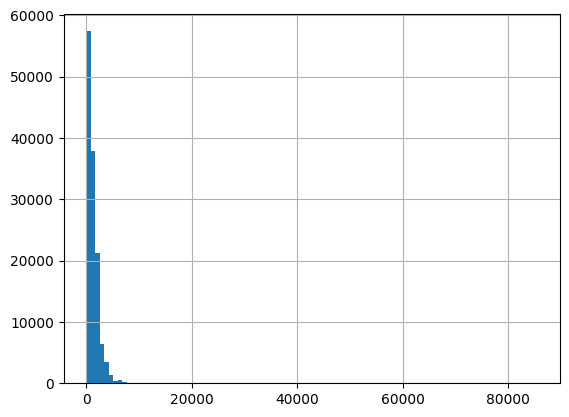

In [50]:
df_purchases['price'].hist(bins=100)

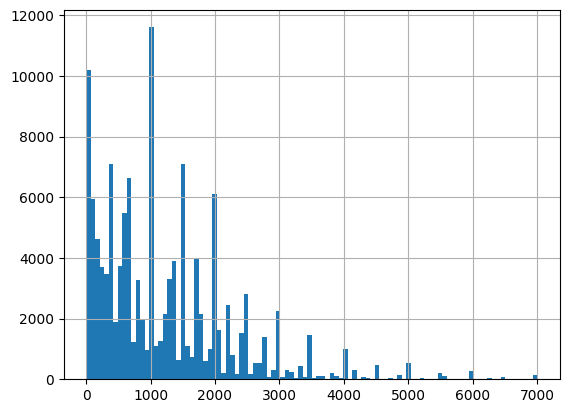

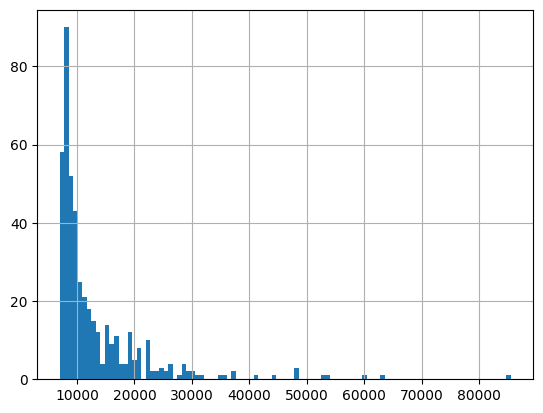

In [51]:
df_purchases[df_purchases['price']<=7000]['price'].hist(bins=100)
plt.show()
df_purchases[df_purchases['price']>7000]['price'].hist(bins=100)
plt.show()


In [52]:
df_purchases[df_purchases['price']>7000]['price'].describe()

count      453.000000
mean     13083.935982
std       8653.335619
min       7037.000000
25%       7999.000000
50%       9999.000000
75%      14999.000000
max      85499.000000
Name: price, dtype: float64

Очевидно недостоверных данных нет, но есть несколько значений, которые сильно выбиваются из общего ряда, но, вероятно, эти польщователи далее будут появляться в df_targets. Оставим пока как есть

#### Date


Посмотрим на date


In [53]:
df_purchases['date'].describe()


count                           129188
mean     2023-02-26 07:40:09.771805440
min                2022-05-16 00:00:00
25%                2022-09-09 00:00:00
50%                2023-03-22 00:00:00
75%                2023-06-28 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

In [54]:
df_purchases['date'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(10)


date
2022-11-11    0.021736
2023-06-10    0.018237
2023-04-28    0.015365
2022-06-02    0.013593
2022-11-15    0.012819
2022-12-22    0.011495
2022-11-12    0.011325
2022-12-21    0.011208
2022-06-01    0.011100
2022-06-03    0.010806
Name: proportion, dtype: object

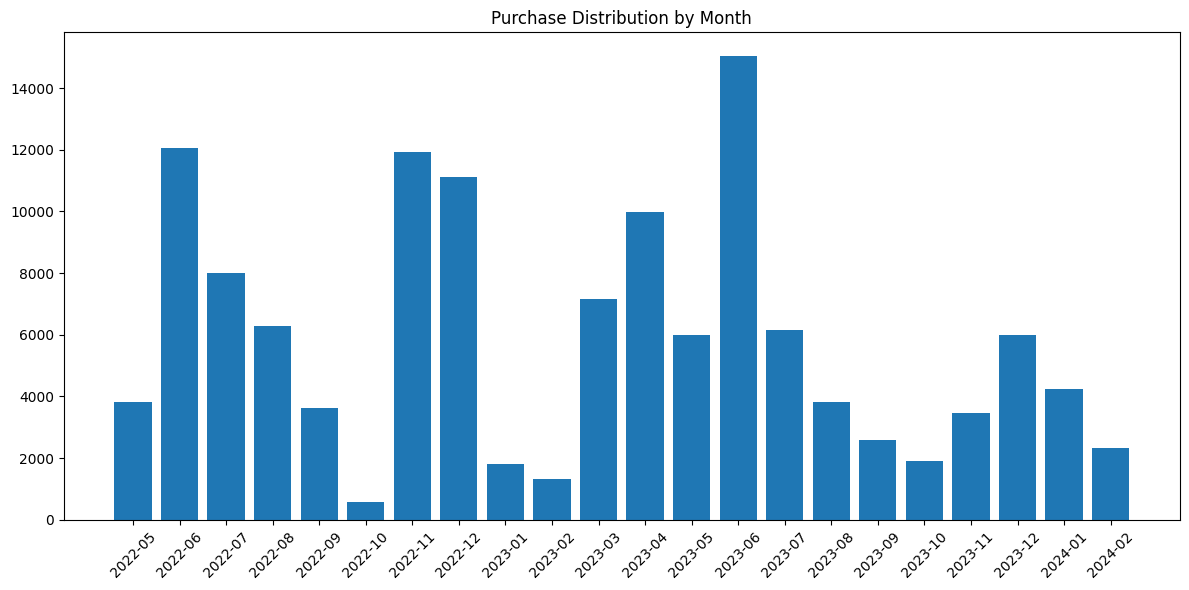

In [55]:
monthly_counts = df_purchases['date'].dt.to_period('M').value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(monthly_counts.index.astype(str), monthly_counts.values)
plt.xticks(rotation=45)
plt.title('Purchase Distribution by Month')
plt.tight_layout()
plt.show()

Года отличаются довольно сильно, но в целом покупок в интересующие нас месяцы в 2023 году больше

На этом пока закончим изучение данных в df_purchases, перейдем к df_messages


#### Messages

In [56]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 774.6+ MB


#### Event


In [57]:
df_messages['event'].value_counts(sort=True).map('{:.6f}'.format).head(10)


event
send           9058174.000000
open           3052481.000000
click           483326.000000
purchase         62593.000000
hard_bounce      19763.000000
soft_bounce      10582.000000
unsubscribe       2833.000000
hbq_spam           823.000000
complain           527.000000
subscribe           85.000000
Name: count, dtype: object

In [58]:
df_messages[df_messages['event']!='send']['client_id'].unique().shape


(52376,)

In [59]:
df_messages[df_messages['event']=='send']['client_id'].unique().shape

(53303,)

Пожохе псылают рассылки всем, но дальше есть ещё категории, когда сообщение отправлено, но не открыто, не баунс и т.д.


In [60]:
df_event_stats = df_messages.groupby(['client_id', 'event']).size().unstack(fill_value=0)
df_event_stats['unopened'] = df_event_stats['send'] - df_event_stats['open']
df_event_stats['unclicked_opens'] = df_event_stats['open'] - df_event_stats['click']
df_event_stats['unpurchased_clicks'] = df_event_stats['click'] - df_event_stats['purchase']
df_event_stats = df_event_stats.reset_index()
df_event_stats.head()

event            client_id  click  close  complain  hard_bounce  hbq_spam  \
0      1515915625468060902     10      0         0            0         0   
1      1515915625468061003      5      0         0            0         0   
2      1515915625468061099      8      0         0            2         0   
3      1515915625468061100      1      0         0            1         0   
4      1515915625468061170     16      0         0            0         0   

event  open  purchase  send  soft_bounce  subscribe  unsubscribe  unopened  \
0        35         5   126            0          0            1        91   
1         5         1   154            0          0            0       149   
2        51         0   215            0          0            0       164   
3       157         1   267            1          0            0       110   
4        31         3   243            0          0            0       212   

event  unclicked_opens  unpurchased_clicks  
0                   25                   5  
1                    0                   4  
2                   43                   8  
3                  156                   0  
4                   15                  13

В принципе, нас только event и интересовал в df_messages, поэтому можем переходить к признакам. Остальные два df выглядят как обычная аггрегация

### Признаки

#### Базовые группировки

In [61]:
df_purchases['price'] = df_purchases['price'].astype(float)
df_purchases['quantity'] = df_purchases['quantity'].astype(float)
df_purchases['c_cat_1'] = df_purchases['c_cat_1'].astype(float)
df_purchases['c_cat_2'] = df_purchases['c_cat_2'].astype(float)
df_purchases['c_cat_3'] = df_purchases['c_cat_3'].astype(float)

Начнем числа покупок, общей суммы и средней суммы покупки

In [62]:
df_stats = df_purchases.groupby('client_id')['price'].agg(['count', 'sum', 'mean']).reset_index()
df_stats.columns = ['client_id', 'purchases_count', 'purchases_sum', 'purchases_mean']
df_stats.head()

client_id  purchases_count  purchases_sum  purchases_mean
0  1515915625468060902                5         4795.0      959.000000
1  1515915625468061003                6        14135.0     2355.833333
2  1515915625468061099                1          299.0      299.000000
3  1515915625468061100                1         1049.0     1049.000000
4  1515915625468061170                8        14102.0     1762.750000

In [63]:
df_stats = df_stats.merge(
    df_event_stats[['client_id','send', 'open', 'unopened', 'unclicked_opens', 'unpurchased_clicks']]
    , on='client_id', how='left')


In [64]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           49849 non-null  int64  
 1   purchases_count     49849 non-null  int64  
 2   purchases_sum       49849 non-null  float64
 3   purchases_mean      49849 non-null  float64
 4   send                41982 non-null  float64
 5   open                41982 non-null  float64
 6   unopened            41982 non-null  float64
 7   unclicked_opens     41982 non-null  float64
 8   unpurchased_clicks  41982 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 3.4 MB


Найдем дату первой и последней покупки для каждого клиента

In [65]:
df_purchases['date'] = pd.to_datetime(df_purchases['date'], errors='coerce')
df_stats_ = df_purchases.groupby('client_id')['date'].agg(['min', 'max']).reset_index()
df_stats_.columns = ['client_id', 'first_purchase_date', 'last_purchase_date']
df_stats_['first_purchase_date'] = pd.to_datetime(df_stats_['first_purchase_date'])
df_stats_['last_purchase_date'] = pd.to_datetime(df_stats_['last_purchase_date'])
df_stats_['first_purchase_span'] = (pd.Timestamp('2024-03-01')- pd.to_datetime(df_stats_['first_purchase_date'])).dt.days


df_stats_.head()


client_id first_purchase_date last_purchase_date  \
0  1515915625468060902          2022-05-27         2022-05-27   
1  1515915625468061003          2023-01-04         2023-01-04   
2  1515915625468061099          2022-05-17         2022-05-17   
3  1515915625468061100          2024-02-10         2024-02-10   
4  1515915625468061170          2023-03-26         2023-06-17   

   first_purchase_span  
0                  644  
1                  422  
2                  654  
3                   20  
4                  341

In [66]:
df_stats = df_stats.merge(df_stats_, on='client_id', how='inner')
df_stats.head()


client_id  purchases_count  purchases_sum  purchases_mean   send  \
0  1515915625468060902                5         4795.0      959.000000  126.0   
1  1515915625468061003                6        14135.0     2355.833333  154.0   
2  1515915625468061099                1          299.0      299.000000  215.0   
3  1515915625468061100                1         1049.0     1049.000000  267.0   
4  1515915625468061170                8        14102.0     1762.750000  243.0   

    open  unopened  unclicked_opens  unpurchased_clicks first_purchase_date  \
0   35.0      91.0             25.0                 5.0          2022-05-27   
1    5.0     149.0              0.0                 4.0          2023-01-04   
2   51.0     164.0             43.0                 8.0          2022-05-17   
3  157.0     110.0            156.0                 0.0          2024-02-10   
4   31.0     212.0             15.0                13.0          2023-03-26   

  last_purchase_date  first_purchase_span  
0         2022-05-27                  644  
1         2023-01-04                  422  
2         2022-05-17                  654  
3         2024-02-10                   20  
4         2023-06-17                  341

In [67]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   client_id            49849 non-null  int64         
 1   purchases_count      49849 non-null  int64         
 2   purchases_sum        49849 non-null  float64       
 3   purchases_mean       49849 non-null  float64       
 4   send                 41982 non-null  float64       
 5   open                 41982 non-null  float64       
 6   unopened             41982 non-null  float64       
 7   unclicked_opens      41982 non-null  float64       
 8   unpurchased_clicks   41982 non-null  float64       
 9   first_purchase_date  49849 non-null  datetime64[ns]
 10  last_purchase_date   49849 non-null  datetime64[ns]
 11  first_purchase_span  49849 non-null  int64         
dtypes: datetime64[ns](2), float64(7), int64(3)
memory usage: 4.6 MB


Создадим признак, который будет показывать, сколько времени прошло с первой до последней покупки

In [68]:
df_stats['purchase_span'] = df_stats['last_purchase_date'] - df_stats['first_purchase_date']
df_stats.head()

client_id  purchases_count  purchases_sum  purchases_mean   send  \
0  1515915625468060902                5         4795.0      959.000000  126.0   
1  1515915625468061003                6        14135.0     2355.833333  154.0   
2  1515915625468061099                1          299.0      299.000000  215.0   
3  1515915625468061100                1         1049.0     1049.000000  267.0   
4  1515915625468061170                8        14102.0     1762.750000  243.0   

    open  unopened  unclicked_opens  unpurchased_clicks first_purchase_date  \
0   35.0      91.0             25.0                 5.0          2022-05-27   
1    5.0     149.0              0.0                 4.0          2023-01-04   
2   51.0     164.0             43.0                 8.0          2022-05-17   
3  157.0     110.0            156.0                 0.0          2024-02-10   
4   31.0     212.0             15.0                13.0          2023-03-26   

  last_purchase_date  first_purchase_span purchase_span  
0         2022-05-27                  644        0 days  
1         2023-01-04                  422        0 days  
2         2022-05-17                  654        0 days  
3         2024-02-10                   20        0 days  
4         2023-06-17                  341       83 days

Добавим признаки, которые будут показывать, какие категории чаще всего встречались в покупках клиентов

In [69]:

#df_stats['c_cat_a1'] = df_purchases.groupby('client_id')['c_cat_1'].agg(
#    lambda x: x.value_counts().index[0] if not x.value_counts().empty else 0).reset_index()['c_cat_1'].astype(int)  
df_stats['c_cat_a2'] = df_purchases.groupby('client_id')['c_cat_1'].agg(
    lambda x: x.value_counts().index[1] if len(x.value_counts()) > 1 else 0).reset_index()['c_cat_1'].astype(int)
df_stats['c_cat_a3'] = df_purchases.groupby('client_id')['c_cat_1'].agg(
    lambda x: x.value_counts().index[2] if len(x.value_counts()) > 2 else 0).reset_index()['c_cat_1'].astype(int)
#df_stats['c_cat_a4'] = df_purchases.groupby('client_id')['c_cat_1'].agg(
#    lambda x: x.value_counts().index[3] if len(x.value_counts()) > 3 else 0).reset_index()['c_cat_1'].astype(int)

df_stats['c_cat_b1'] = df_purchases.groupby('client_id')['c_cat_2'].agg(
    lambda x: x.value_counts().index[0] if not x.value_counts().empty else 0).reset_index()['c_cat_2'].astype(int)  
df_stats['c_cat_b2'] = df_purchases.groupby('client_id')['c_cat_2'].agg(
    lambda x: x.value_counts().index[1] if len(x.value_counts()) > 1 else 0).reset_index()['c_cat_2'].astype(int)
df_stats['c_cat_b3'] = df_purchases.groupby('client_id')['c_cat_2'].agg(
    lambda x: x.value_counts().index[2] if len(x.value_counts()) > 2 else 0).reset_index()['c_cat_2'].astype(int)
#df_stats['c_cat_b4'] = df_purchases.groupby('client_id')['c_cat_2'].agg(
#    lambda x: x.value_counts().index[3] if len(x.value_counts()) > 3 else 0).reset_index()['c_cat_2'].astype(int)

df_stats['c_cat_c1'] = df_purchases.groupby('client_id')['c_cat_3'].agg(
    lambda x: x.value_counts().index[0] if not x.value_counts().empty else 0).reset_index()['c_cat_3'].astype(int)  
df_stats['c_cat_c2'] = df_purchases.groupby('client_id')['c_cat_3'].agg(
    lambda x: x.value_counts().index[1] if len(x.value_counts()) > 1 else 0).reset_index()['c_cat_3'].astype(int)
df_stats['c_cat_c3'] = df_purchases.groupby('client_id')['c_cat_3'].agg(
    lambda x: x.value_counts().index[2] if len(x.value_counts()) > 2 else 0).reset_index()['c_cat_3'].astype(int)
#df_stats['c_cat_c4'] = df_purchases.groupby('client_id')['c_cat_3'].agg(
#    lambda x: x.value_counts().index[3] if len(x.value_counts()) > 3 else 0).reset_index()['c_cat_3'].astype(int)



a_1 не взяли, потому что там большая доля в топ-4, оставшиеся 3 практически дадут 1 признак

In [70]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   client_id            49849 non-null  int64          
 1   purchases_count      49849 non-null  int64          
 2   purchases_sum        49849 non-null  float64        
 3   purchases_mean       49849 non-null  float64        
 4   send                 41982 non-null  float64        
 5   open                 41982 non-null  float64        
 6   unopened             41982 non-null  float64        
 7   unclicked_opens      41982 non-null  float64        
 8   unpurchased_clicks   41982 non-null  float64        
 9   first_purchase_date  49849 non-null  datetime64[ns] 
 10  last_purchase_date   49849 non-null  datetime64[ns] 
 11  first_purchase_span  49849 non-null  int64          
 12  purchase_span        49849 non-null  timedelta64[ns]
 13  c_cat_a2        

Добавим признак, который будет показывать, насколько часто клиент совершает покупки

In [71]:
df_stats['purchase_frequency'] = (df_stats['first_purchase_span']/df_stats['purchases_count']) 
df_stats.head()

client_id  purchases_count  purchases_sum  purchases_mean   send  \
0  1515915625468060902                5         4795.0      959.000000  126.0   
1  1515915625468061003                6        14135.0     2355.833333  154.0   
2  1515915625468061099                1          299.0      299.000000  215.0   
3  1515915625468061100                1         1049.0     1049.000000  267.0   
4  1515915625468061170                8        14102.0     1762.750000  243.0   

    open  unopened  unclicked_opens  unpurchased_clicks first_purchase_date  \
0   35.0      91.0             25.0                 5.0          2022-05-27   
1    5.0     149.0              0.0                 4.0          2023-01-04   
2   51.0     164.0             43.0                 8.0          2022-05-17   
3  157.0     110.0            156.0                 0.0          2024-02-10   
4   31.0     212.0             15.0                13.0          2023-03-26   

  last_purchase_date  first_purchase_span purchase_span  c_cat_a2  c_cat_a3  \
0         2022-05-27                  644        0 days         0         0   
1         2023-01-04                  422        0 days         0         0   
2         2022-05-17                  654        0 days         0         0   
3         2024-02-10                   20        0 days         0         0   
4         2023-06-17                  341       83 days         0         2   

   c_cat_b1  c_cat_b2  c_cat_b3  c_cat_c1  c_cat_c2  c_cat_c3  \
0        28        27         0         0       260      1828   
1        28         0         0       249         0         0   
2        28         0         0       290         0         0   
3        27         0         0      1828         0         0   
4        28         0        18       260         0       258   

   purchase_frequency  
0          128.800000  
1           70.333333  
2          654.000000  
3           20.000000  
4           42.625000

Количество товаров в одной покупке нас не интересует

#### Channel

Попробуем добавить признаки, которые будут показывать, как клиент реагирует на рассылки

In [72]:
df_messages.head()

bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   
3              4439  1515915625553578558   
4              4439  1515915625471518311   

                               message_id  event channel       date  \
0  1515915625626736623-4439-6283415ac07ea   open   email 2022-05-19   
1  1515915625490086521-4439-62834150016dd   open   email 2022-05-19   
2  1515915625553578558-4439-6283415b36b4f   open   email 2022-05-19   
3  1515915625553578558-4439-6283415b36b4f  click   email 2022-05-19   
4  1515915625471518311-4439-628341570c133   open   email 2022-05-19   

            created_at  
0  2022-05-19 00:14:20  
1  2022-05-19 00:39:34  
2  2022-05-19 00:51:49  
3  2022-05-19 00:52:20  
4  2022-05-19 00:56:52

In [73]:
df_messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

Канала рассылок всего два, email и mobile_push

In [74]:
df_messages[df_messages['channel']=='email']['event'].value_counts(normalize=True).map('{:.6f}'.format)

event
send           0.754153
open           0.167245
click          0.067414
purchase       0.008469
soft_bounce    0.001832
unsubscribe    0.000543
hbq_spam       0.000158
complain       0.000101
hard_bounce    0.000069
subscribe      0.000016
Name: proportion, dtype: object

In [75]:
df_messages[df_messages['channel']=='mobile_push']['event'].value_counts(normalize=True).map('{:.6f}'.format)

event
send           0.685493
open           0.291728
click          0.017586
hard_bounce    0.002597
purchase       0.002460
soft_bounce    0.000136
close          0.000000
Name: proportion, dtype: object

Поведение клиентов по каналам рассылок отличается

In [76]:
df_msg_share = df_messages.groupby(['client_id'])['channel'].value_counts(normalize=True).reset_index()
df_msg_share.columns = ['client_id', 'channel', 'share']
df_msg_share.head()

client_id      channel    share
0  1515915625468060902        email  1.00000
1  1515915625468061003        email  1.00000
2  1515915625468061099        email  0.65942
3  1515915625468061099  mobile_push  0.34058
4  1515915625468061100  mobile_push  1.00000

Создадим признак, какую долю трафика получали клиенты через mobile_push

In [77]:
df_msg_share_pivot = df_msg_share.pivot(index='client_id', columns='channel', values='share').reset_index()
df_msg_share_pivot = df_msg_share_pivot.fillna(0)
df_msg_share_pivot.drop(columns=['email'], inplace=True)
df_stats = df_stats.merge(df_msg_share_pivot, on='client_id', how='left')
df_stats.head()

client_id  purchases_count  purchases_sum  purchases_mean   send  \
0  1515915625468060902                5         4795.0      959.000000  126.0   
1  1515915625468061003                6        14135.0     2355.833333  154.0   
2  1515915625468061099                1          299.0      299.000000  215.0   
3  1515915625468061100                1         1049.0     1049.000000  267.0   
4  1515915625468061170                8        14102.0     1762.750000  243.0   

    open  unopened  unclicked_opens  unpurchased_clicks first_purchase_date  \
0   35.0      91.0             25.0                 5.0          2022-05-27   
1    5.0     149.0              0.0                 4.0          2023-01-04   
2   51.0     164.0             43.0                 8.0          2022-05-17   
3  157.0     110.0            156.0                 0.0          2024-02-10   
4   31.0     212.0             15.0                13.0          2023-03-26   

  last_purchase_date  first_purchase_span purchase_span  c_cat_a2  c_cat_a3  \
0         2022-05-27                  644        0 days         0         0   
1         2023-01-04                  422        0 days         0         0   
2         2022-05-17                  654        0 days         0         0   
3         2024-02-10                   20        0 days         0         0   
4         2023-06-17                  341       83 days         0         2   

   c_cat_b1  c_cat_b2  c_cat_b3  c_cat_c1  c_cat_c2  c_cat_c3  \
0        28        27         0         0       260      1828   
1        28         0         0       249         0         0   
2        28         0         0       290         0         0   
3        27         0         0      1828         0         0   
4        28         0        18       260         0       258   

   purchase_frequency  mobile_push  
0          128.800000      0.00000  
1           70.333333      0.00000  
2          654.000000      0.34058  
3           20.000000      1.00000  
4           42.625000      0.31058

#### Bulk

In [78]:
df_messages['bulk_campaign_id'].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(10)

bulk_campaign_id
14272    0.008199
14276    0.004993
4679     0.003989
11760    0.003604
14081    0.003472
14623    0.003470
14515    0.003443
12218    0.003225
14352    0.003150
14356    0.003052
Name: proportion, dtype: object

In [79]:
df_messages[(df_messages['date']>='2023-03-01') & (df_messages['date']<'2023-06-01')][['bulk_campaign_id']].value_counts(normalize=True, sort=True).map('{:.6f}'.format).head(10)


bulk_campaign_id
11760               0.037631
12218               0.033660
11208               0.028470
11144               0.027906
10507               0.024556
11952               0.022755
12911               0.022581
12650               0.022231
12864               0.021843
12252               0.020926
Name: proportion, dtype: object

In [80]:
all_time_counts = df_messages['bulk_campaign_id'].value_counts(normalize=True, sort=True).head(20)
period_counts = df_messages[(df_messages['date']>='2023-03-01') & 
                          (df_messages['date']<'2023-06-01')][['bulk_campaign_id']].value_counts(normalize=True, sort=True).head(20)

common_campaigns = set(all_time_counts.index).intersection(set(period_counts.index))

print(f"Common campaign IDs in top 20: {len(common_campaigns)}")

Common campaign IDs in top 20: 0


In [81]:
all_time_counts = df_messages['bulk_campaign_id'].value_counts(normalize=True, sort=True).head(20)
period_counts = df_messages[(df_messages['date']>='2023-12-01') & 
                          (df_messages['date']<'2023-12-31')][['bulk_campaign_id']].value_counts(normalize=True, sort=True).head(20)

common_campaigns = set(all_time_counts.index).intersection(set(period_counts.index))

print(f"Common campaign IDs in top 20: {len(common_campaigns)}")

Common campaign IDs in top 20: 0


In [82]:
campaign_dates = df_messages.groupby('bulk_campaign_id').agg({
    'date': ['min', 'max', 'count'] 
}).reset_index()
campaign_dates.columns = ['bulk_campaign_id', 'start_date', 'end_date', 'message_count']

campaign_dates['duration_days'] = (campaign_dates['end_date'] - campaign_dates['start_date']).dt.days

print('Top campaigns by message volume:')
print(campaign_dates.sort_values('message_count', ascending=False).head(20))

Top campaigns by message volume:
      bulk_campaign_id start_date   end_date  message_count  duration_days
2371             14272 2023-12-08 2024-01-07         104060             30
2375             14276 2023-12-09 2024-01-08          63362             30
188               4679 2022-06-01 2023-05-29          50621            362
1288             11760 2023-04-12 2023-11-22          45745            224
2211             14081 2023-11-09 2023-11-30          44067             21
2675             14623 2024-02-09 2024-02-15          44044              6
2581             14515 2024-01-22 2024-02-15          43700             24
1354             12218 2023-04-28 2023-11-01          40926            187
2440             14352 2023-12-22 2024-01-21          39983             30
2443             14356 2023-12-23 2024-01-22          38729             30
1972             13821 2023-09-23 2023-09-30          38548              7
2445             14359 2023-12-24 2024-01-23          38163        

In [83]:
print('Longest running campaigns:')
print(campaign_dates.sort_values('duration_days', ascending=False).head(20))

Longest running campaigns:
     bulk_campaign_id start_date   end_date  message_count  duration_days
148              4052 2022-05-19 2024-02-01            172            623
113              3001 2022-05-20 2024-01-16             78            606
144              3948 2022-05-19 2024-01-12            235            603
169              4517 2022-05-23 2024-01-16          12558            603
74               2090 2022-05-29 2023-12-28             21            578
121              3169 2022-05-20 2023-12-18            126            577
154              4273 2022-05-19 2023-12-14            580            574
132              3557 2022-05-19 2023-12-02            460            562
42               1409 2022-05-23 2023-12-05             23            561
119              3131 2022-05-19 2023-11-26            106            556
133              3578 2022-05-20 2023-11-23             81            552
127              3401 2022-05-20 2023-11-14            373            543
63         

In [84]:
campaign_dates[campaign_dates['end_date']>'2024-02-09'].sort_values('message_count', ascending=False).head(10)

bulk_campaign_id start_date   end_date  message_count  duration_days
2675             14623 2024-02-09 2024-02-15          44044              6
2581             14515 2024-01-22 2024-02-15          43700             24
2527             14456 2024-01-11 2024-02-10          37603             30
2585             14521 2024-01-23 2024-02-15          36325             23
2214             14085 2023-11-10 2024-02-14          34421             96
2591             14529 2024-01-24 2024-02-15          34123             22
2458             14376 2023-12-22 2024-02-14          33197             54
2510             14439 2024-01-06 2024-02-14          32537             39
2493             14419 2023-12-30 2024-02-15          31846             47
2693             14641 2024-02-13 2024-02-15          30871              2

Мы видим, что некоторые рассылки продолжаются довольно долго, но большинство самых массовых рассылок гораздо короче. Какой признак из этого можно сделать пока непонятно, запомним на будущее

#### Last opened

Теоретически может быть полезный признак, который будет показывать, сколько времени прошло с последнего открытия рассылки до 2024-02-15. Может пользователь не просто давно не покупал, но и давно ничего не открывал в принципе.


In [85]:
df_purchases['date'].max()

Timestamp('2024-02-16 00:00:00')

In [86]:
df_messages['date'].max()

Timestamp('2024-02-15 00:00:00')

In [87]:
last_opens = df_messages[df_messages['event']=='open'].groupby('client_id')['date'].max().reset_index()
last_opens['last_open'] = (pd.Timestamp('2024-03-01') - last_opens['date']).dt.days

df_stats = df_stats.merge(last_opens[['client_id', 'last_open']], on='client_id', how='left')


### Доработка признаков

In [88]:
df_targets = df_targets.merge(df_stats, on='client_id', how='inner')
df_targets.head()


client_id  target  purchases_count  purchases_sum  \
0  1515915625468060902       0                5         4795.0   
1  1515915625468061003       1                6        14135.0   
2  1515915625468061099       0                1          299.0   
3  1515915625468061100       0                1         1049.0   
4  1515915625468061170       0                8        14102.0   

   purchases_mean   send   open  unopened  unclicked_opens  \
0      959.000000  126.0   35.0      91.0             25.0   
1     2355.833333  154.0    5.0     149.0              0.0   
2      299.000000  215.0   51.0     164.0             43.0   
3     1049.000000  267.0  157.0     110.0            156.0   
4     1762.750000  243.0   31.0     212.0             15.0   

   unpurchased_clicks first_purchase_date last_purchase_date  \
0                 5.0          2022-05-27         2022-05-27   
1                 4.0          2023-01-04         2023-01-04   
2                 8.0          2022-05-17         2022-05-17   
3                 0.0          2024-02-10         2024-02-10   
4                13.0          2023-03-26         2023-06-17   

   first_purchase_span purchase_span  c_cat_a2  c_cat_a3  c_cat_b1  c_cat_b2  \
0                  644        0 days         0         0        28        27   
1                  422        0 days         0         0        28         0   
2                  654        0 days         0         0        28         0   
3                   20        0 days         0         0        27         0   
4                  341       83 days         0         2        28         0   

   c_cat_b3  c_cat_c1  c_cat_c2  c_cat_c3  purchase_frequency  mobile_push  \
0         0         0       260      1828          128.800000      0.00000   
1         0       249         0         0           70.333333      0.00000   
2         0       290         0         0          654.000000      0.34058   
3         0      1828         0         0           20.000000      1.00000   
4        18       260         0       258           42.625000      0.31058   

   last_open  
0       42.0  
1      101.0  
2       38.0  
3       15.0  
4       85.0

In [89]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   client_id            49849 non-null  int64          
 1   target               49849 non-null  int64          
 2   purchases_count      49849 non-null  int64          
 3   purchases_sum        49849 non-null  float64        
 4   purchases_mean       49849 non-null  float64        
 5   send                 41982 non-null  float64        
 6   open                 41982 non-null  float64        
 7   unopened             41982 non-null  float64        
 8   unclicked_opens      41982 non-null  float64        
 9   unpurchased_clicks   41982 non-null  float64        
 10  first_purchase_date  49849 non-null  datetime64[ns] 
 11  last_purchase_date   49849 non-null  datetime64[ns] 
 12  first_purchase_span  49849 non-null  int64          
 13  purchase_span   

In [90]:
df_targets.isna().sum()

client_id                  0
target                     0
purchases_count            0
purchases_sum              0
purchases_mean             0
send                    7867
open                    7867
unopened                7867
unclicked_opens         7867
unpurchased_clicks      7867
first_purchase_date        0
last_purchase_date         0
first_purchase_span        0
purchase_span              0
c_cat_a2                   0
c_cat_a3                   0
c_cat_b1                   0
c_cat_b2                   0
c_cat_b3                   0
c_cat_c1                   0
c_cat_c2                   0
c_cat_c3                   0
purchase_frequency         0
mobile_push             7867
last_open              15102
dtype: int64

Выглядит так, что почти 8 тысяч клиентов не получили ни одной рассылки перед покупкой

Добавим признак, который будет показывать, сколько времени прошло с последней покупки до 2024-03-01 и уберем даты

In [91]:
df_targets['recent_purchase'] = (df_targets['last_purchase_date'] - pd.Timestamp('2024-03-01')).dt.days
df_targets.head()

client_id  target  purchases_count  purchases_sum  \
0  1515915625468060902       0                5         4795.0   
1  1515915625468061003       1                6        14135.0   
2  1515915625468061099       0                1          299.0   
3  1515915625468061100       0                1         1049.0   
4  1515915625468061170       0                8        14102.0   

   purchases_mean   send   open  unopened  unclicked_opens  \
0      959.000000  126.0   35.0      91.0             25.0   
1     2355.833333  154.0    5.0     149.0              0.0   
2      299.000000  215.0   51.0     164.0             43.0   
3     1049.000000  267.0  157.0     110.0            156.0   
4     1762.750000  243.0   31.0     212.0             15.0   

   unpurchased_clicks first_purchase_date last_purchase_date  \
0                 5.0          2022-05-27         2022-05-27   
1                 4.0          2023-01-04         2023-01-04   
2                 8.0          2022-05-17         2022-05-17   
3                 0.0          2024-02-10         2024-02-10   
4                13.0          2023-03-26         2023-06-17   

   first_purchase_span purchase_span  c_cat_a2  c_cat_a3  c_cat_b1  c_cat_b2  \
0                  644        0 days         0         0        28        27   
1                  422        0 days         0         0        28         0   
2                  654        0 days         0         0        28         0   
3                   20        0 days         0         0        27         0   
4                  341       83 days         0         2        28         0   

   c_cat_b3  c_cat_c1  c_cat_c2  c_cat_c3  purchase_frequency  mobile_push  \
0         0         0       260      1828          128.800000      0.00000   
1         0       249         0         0           70.333333      0.00000   
2         0       290         0         0          654.000000      0.34058   
3         0      1828         0         0           20.000000      1.00000   
4        18       260         0       258           42.625000      0.31058   

   last_open  recent_purchase  
0       42.0             -644  
1      101.0             -422  
2       38.0             -654  
3       15.0              -20  
4       85.0             -258

In [92]:
df_targets.drop(columns=['first_purchase_date', 'last_purchase_date'], inplace=True)
df_targets.head()

client_id  target  purchases_count  purchases_sum  \
0  1515915625468060902       0                5         4795.0   
1  1515915625468061003       1                6        14135.0   
2  1515915625468061099       0                1          299.0   
3  1515915625468061100       0                1         1049.0   
4  1515915625468061170       0                8        14102.0   

   purchases_mean   send   open  unopened  unclicked_opens  \
0      959.000000  126.0   35.0      91.0             25.0   
1     2355.833333  154.0    5.0     149.0              0.0   
2      299.000000  215.0   51.0     164.0             43.0   
3     1049.000000  267.0  157.0     110.0            156.0   
4     1762.750000  243.0   31.0     212.0             15.0   

   unpurchased_clicks  first_purchase_span purchase_span  c_cat_a2  c_cat_a3  \
0                 5.0                  644        0 days         0         0   
1                 4.0                  422        0 days         0         0   
2                 8.0                  654        0 days         0         0   
3                 0.0                   20        0 days         0         0   
4                13.0                  341       83 days         0         2   

   c_cat_b1  c_cat_b2  c_cat_b3  c_cat_c1  c_cat_c2  c_cat_c3  \
0        28        27         0         0       260      1828   
1        28         0         0       249         0         0   
2        28         0         0       290         0         0   
3        27         0         0      1828         0         0   
4        28         0        18       260         0       258   

   purchase_frequency  mobile_push  last_open  recent_purchase  
0          128.800000      0.00000       42.0             -644  
1           70.333333      0.00000      101.0             -422  
2          654.000000      0.34058       38.0             -654  
3           20.000000      1.00000       15.0              -20  
4           42.625000      0.31058       85.0             -258

In [93]:
df_targets['purchase_span'] = df_targets['purchase_span'].dt.days

In [94]:
phik_matrix = df_targets.drop(columns=['client_id', 'target']).phik_matrix()
phik_matrix.style.background_gradient(cmap='coolwarm', axis=None)


interval columns not set, guessing: ['purchases_count', 'purchases_sum', 'purchases_mean', 'send', 'open', 'unopened', 'unclicked_opens', 'unpurchased_clicks', 'first_purchase_span', 'purchase_span', 'c_cat_a2', 'c_cat_a3', 'c_cat_b1', 'c_cat_b2', 'c_cat_b3', 'c_cat_c1', 'c_cat_c2', 'c_cat_c3', 'purchase_frequency', 'mobile_push', 'last_open', 'recent_purchase']


Уберем или правим признаки, которые не помогут модели судя по матрице Phix (коллинеарность), малозначимые и не очень информативные пусть убирает регуляризация.

In [95]:
df_targets['unopened_ratio'] = (df_targets['unopened']+1)/(df_targets['send']+1)
df_targets['unclicked_opens_ratio'] = (df_targets['unclicked_opens']+1)/(df_targets['open']+1)
df_targets['unpurchased_clicks_ratio'] = (df_targets['unpurchased_clicks']+1)/(df_targets['open'] - df_targets['unclicked_opens']+1)


In [96]:
df_targets.drop(columns=['open', 'unopened',  'unclicked_opens', 'unpurchased_clicks', 'c_cat_b1', 'c_cat_b2', 'c_cat_b3', 'purchase_frequency', 'first_purchase_span'], inplace=True) 

In [97]:
phik_matrix = df_targets.drop(columns=['client_id', 'target']).phik_matrix()
phik_matrix.style.background_gradient(cmap='coolwarm', axis=None)


interval columns not set, guessing: ['purchases_count', 'purchases_sum', 'purchases_mean', 'send', 'purchase_span', 'c_cat_a2', 'c_cat_a3', 'c_cat_c1', 'c_cat_c2', 'c_cat_c3', 'mobile_push', 'last_open', 'recent_purchase', 'unopened_ratio', 'unclicked_opens_ratio', 'unpurchased_clicks_ratio']


#### Подбор модели

Разделим данные на обучающую и тестовую выборки

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_targets.drop(
    columns=['client_id', 'target']), df_targets['target'], test_size=0.2, random_state=RANDOM_STATE)

Разделим признаки на числовые и категориальные

In [99]:
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in X_train.columns if X_train[col].dtype in ['object', 'str']]


Создадим пайплайн для числовых и категориальных признаков

In [100]:
preprocessor = ColumnTransformer(
     transformers=[
        ('num', StandardScaler(), num_cols)#,
        #('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LGBMClassifier(random_state=RANDOM_STATE))])


Поехали, скейлер решил убрать

In [101]:
param_dist = {
    'preprocessor__num': ['passthrough'], 
    'model__n_estimators': range(200, 400, 10),    
    'model__max_depth': range(5, 15, 2),
    'model__learning_rate': [0.01],
    'model__num_leaves': range(3, 9, 2),
    'model__min_child_samples': range(20, 40, 5),
    'model__max_bin':  [255],
    'model__subsample': [0.6, 0.7, 0.8],
    'model__colsample_bytree': [0.5, 0.6, 0.7],
    'model__lambda_l1': [0.4, 0.6, 0.8],
    'model__lambda_l2': [0.3, 0.5, 0.7],
    'model__is_unbalance': [True]
    }

# Create the RandomizedSearchCV object
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=1000,  
    scoring=roc_auc_scorer,
    cv=5,    
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1 
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions with the best model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC score: {roc_auc:.3f}")

# Print best parameters
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[LightGBM] [Warning] lambda_l1 is set=0.8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] lambda_l1 is set=0.8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] lambda_l1 is set=0.8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] lambda_l1 is set=0.8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] lambda_l1 is set=0.8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8
[Lig

In [104]:
cv_results = pd.DataFrame(random_search.cv_results_)
top_5_params = cv_results.sort_values(by='mean_test_score', ascending=False).head(5)

relevant_columns = ['mean_test_score', 'std_test_score', 'params']
top_5_results = top_5_params[relevant_columns]

for i, row in enumerate(top_5_results.itertuples(), 1):
    print(f"\n## Parameter Set {i}")
    print(f"Mean Score: {row.mean_test_score:.4f}")
    print(f"Standard Deviation: {row.std_test_score:.4f}")
    print("Parameters:")
    for param, value in row.params.items():
        print(f"- {param}: {value}")


## Parameter Set 1
Mean Score: 0.7573
Standard Deviation: 0.0241
Parameters:
- preprocessor__num: passthrough
- model__subsample: 0.8
- model__num_leaves: 5
- model__n_estimators: 390
- model__min_child_samples: 25
- model__max_depth: 11
- model__max_bin: 255
- model__learning_rate: 0.01
- model__lambda_l2: 0.3
- model__lambda_l1: 0.4
- model__is_unbalance: True
- model__colsample_bytree: 0.6

## Parameter Set 2
Mean Score: 0.7573
Standard Deviation: 0.0250
Parameters:
- preprocessor__num: passthrough
- model__subsample: 0.6
- model__num_leaves: 5
- model__n_estimators: 370
- model__min_child_samples: 20
- model__max_depth: 11
- model__max_bin: 255
- model__learning_rate: 0.01
- model__lambda_l2: 0.5
- model__lambda_l1: 0.6
- model__is_unbalance: True
- model__colsample_bytree: 0.5

## Parameter Set 3
Mean Score: 0.7572
Standard Deviation: 0.0244
Parameters:
- preprocessor__num: passthrough
- model__subsample: 0.8
- model__num_leaves: 5
- model__n_estimators: 390
- model__min_child_sa

Ну вот, ROC_AUC 0.74. Кажется модель немного переобучилась (на кросс-валидации почти 0.76), но не критично.


### Feature Importance

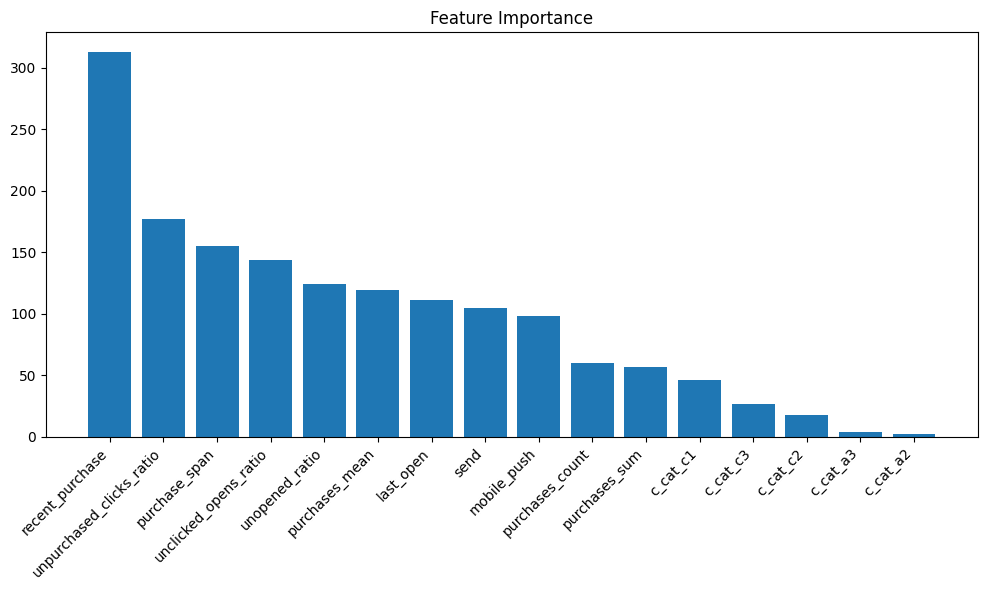

In [103]:
feature_names = X_train.columns.tolist()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.named_steps['model'].feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

Ну результаты получились довольно неудивительные. Лучшие кленты, покупали недавно, часто открывают, кликают и покупают, меньше отваливаясь на каждом этапе и т.д. Разбитые категории товаров оказались не слишком важны, по сравнению с общими параметрами поведения клиентов, то есть мы не обнаружили каких-то невероятных категорий товаров или типов акций, которые бы перевесили обычные предрасположенности среднего клиента. При этом, имеет значение число отправленных рассылок и канал коммуникации с пользователем. В качестве теммы для дальнейших исследований, вероятно стоит поискать грань целесообразности увеличения количества рассылок и наиболее подходящий тайминг (выходные, праздники, время суток). Также, мы считаем, канал коммуникаций важным признаком, вероятно целесообразно повнимательнее посмотреть на отличая между реакцией на предложения полученные через пуш и по почте. 

Общая доля покупок, кликов и открытий в общем количестве рассылок вероятно зависит от цены, условий, оформления и т.д., но мы делали предсказания на уровне отдельных клиентов. 